Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directorio actual: /content/drive/MyDrive/imagenes_termicas

Carpetas encontradas:
baseline_stats.pkl  resultado_p2001.png  resultado_p9086.png
p1_Noload	    resultado_p2002.png  resultado_p9087.png
p2_80		    resultado_p2003.png  resultado_p9090.png
p3_160		    resultado_p6001.png  resultado_p9095.png
p4_240		    resultado_p6002.png  resultado_p9100.png
p5_320		    resultado_p6003.png  resultado_p9105.png
p6_400		    resultado_p7026.png  resultado_p9110.png
p7_480		    resultado_p7027.png  resultado_p9115.png
p8_560		    resultado_p7028.png  resultado_p9120.png
p9_600		    resultado_p9085.png
SISTEMA DE DETECCIÓN DE SOBRECALENTAMIENTO EN TRANSFORMADORES

✓ Cargando baseline existente...
 Baseline cargado desde: baseline_stats.pkl

📸 PASO 2: Analizando imágenes de prueba
Encontradas 40 imágenes para analizar


 Analizando: p9085.bmp
✓ Visualización guardada e

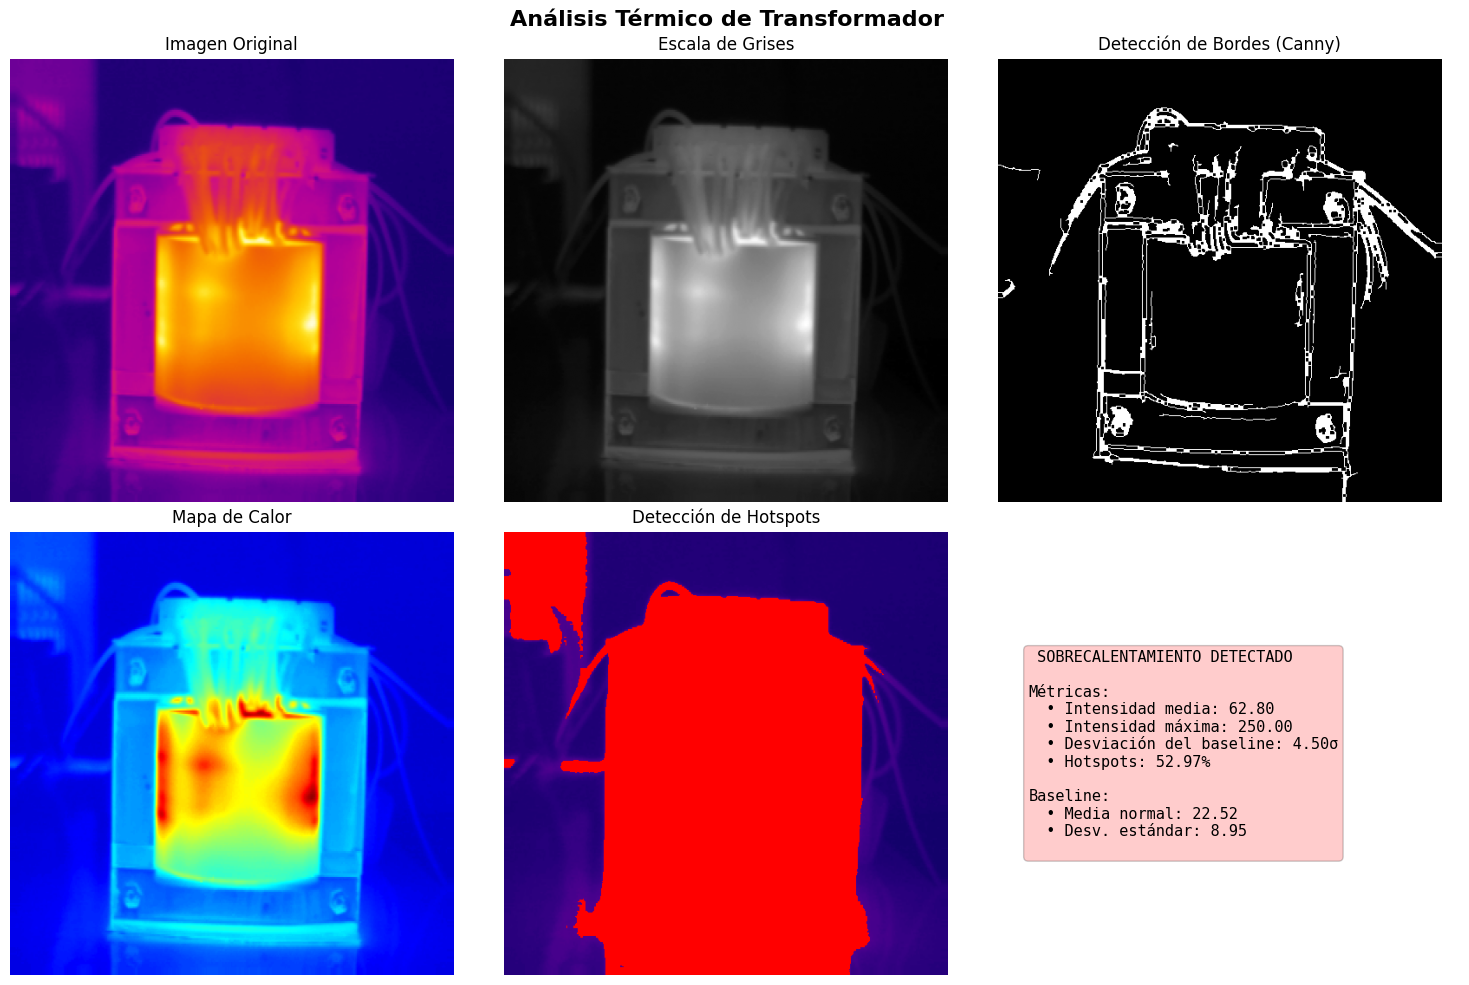

  Resultado:  SOBRECALENTAMIENTO
  Desviación: 4.50σ
  Hotspots: 52.97%
----------------------------------------------------------------------

 Analizando: p9090.bmp
✓ Visualización guardada en: resultado_p9090.png


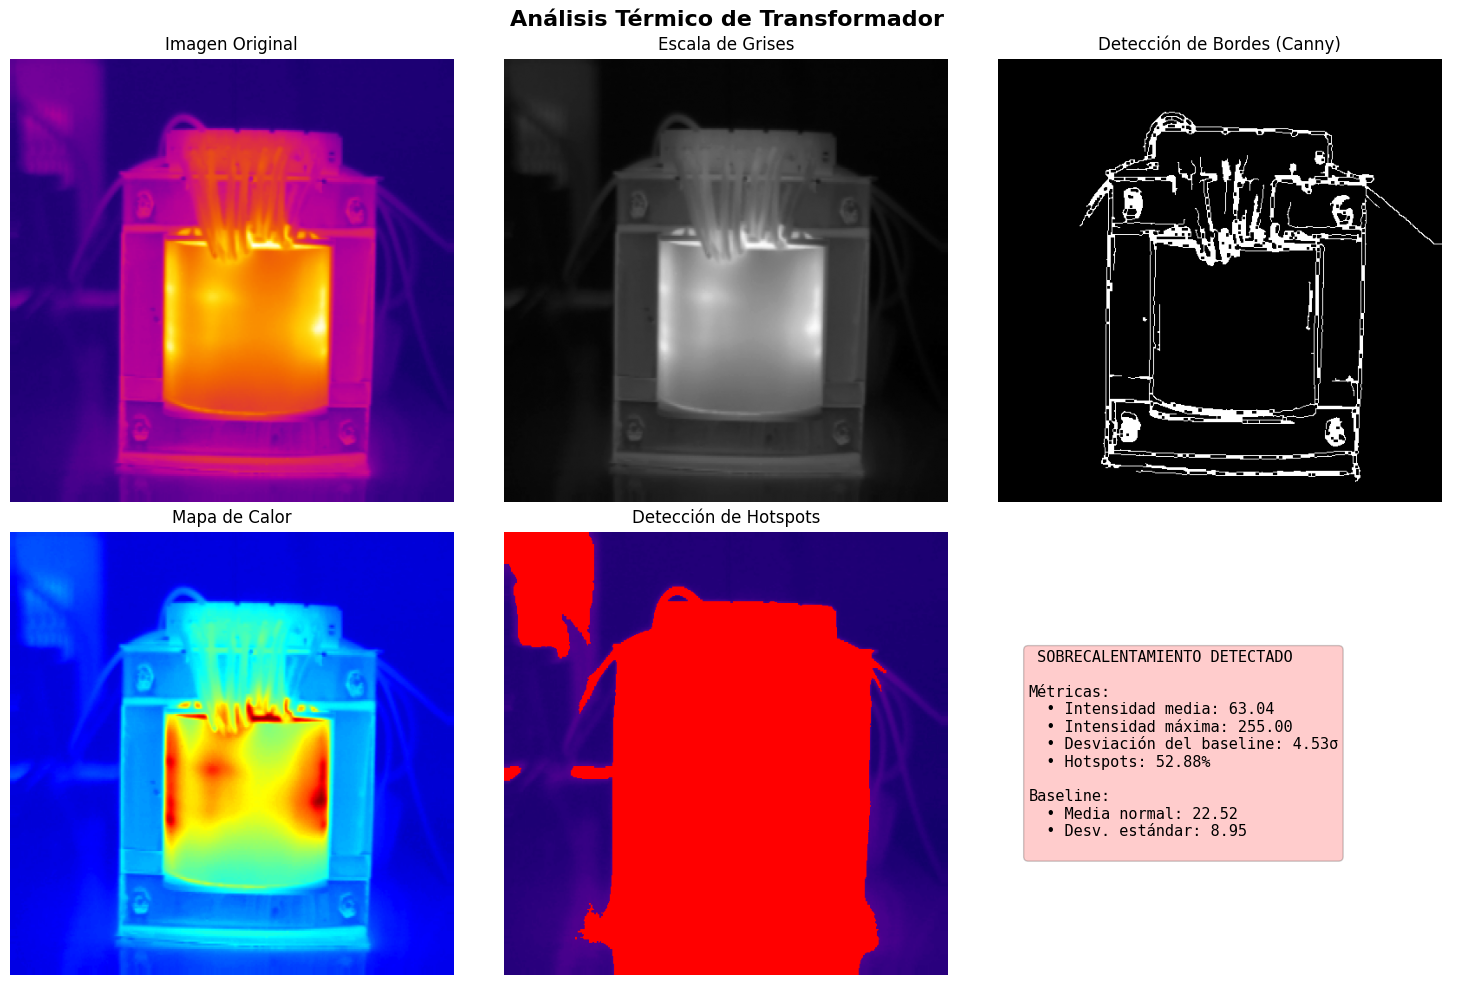

  Resultado:  SOBRECALENTAMIENTO
  Desviación: 4.53σ
  Hotspots: 52.88%
----------------------------------------------------------------------

 Analizando: p9095.bmp
✓ Visualización guardada en: resultado_p9095.png


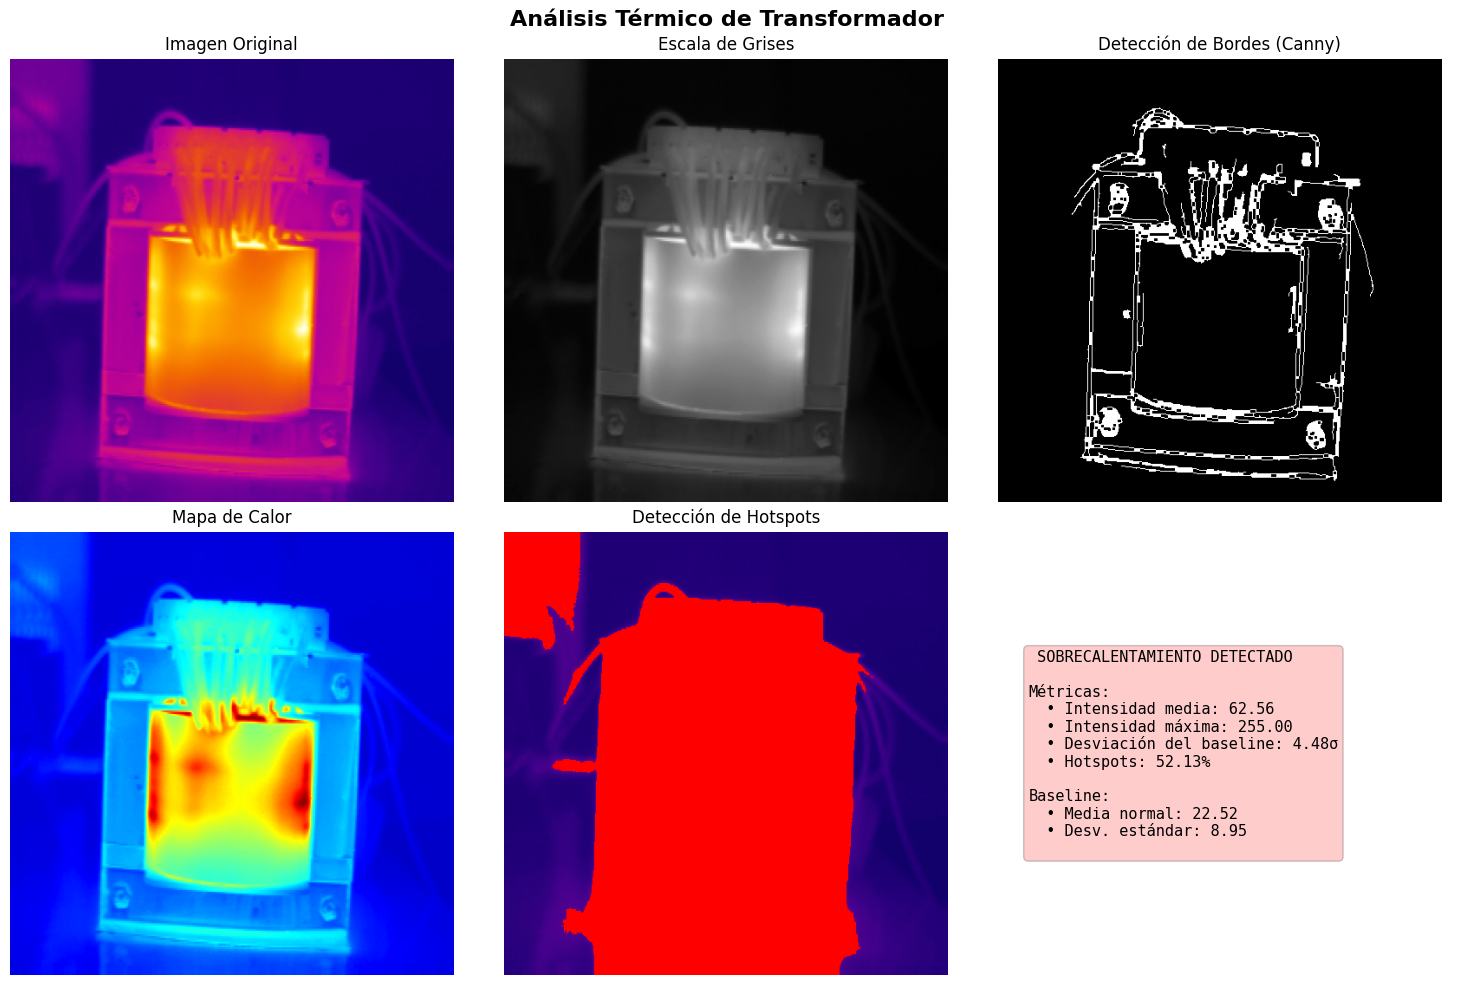

  Resultado:  SOBRECALENTAMIENTO
  Desviación: 4.48σ
  Hotspots: 52.13%
----------------------------------------------------------------------

 Analizando: p9100.bmp
✓ Visualización guardada en: resultado_p9100.png


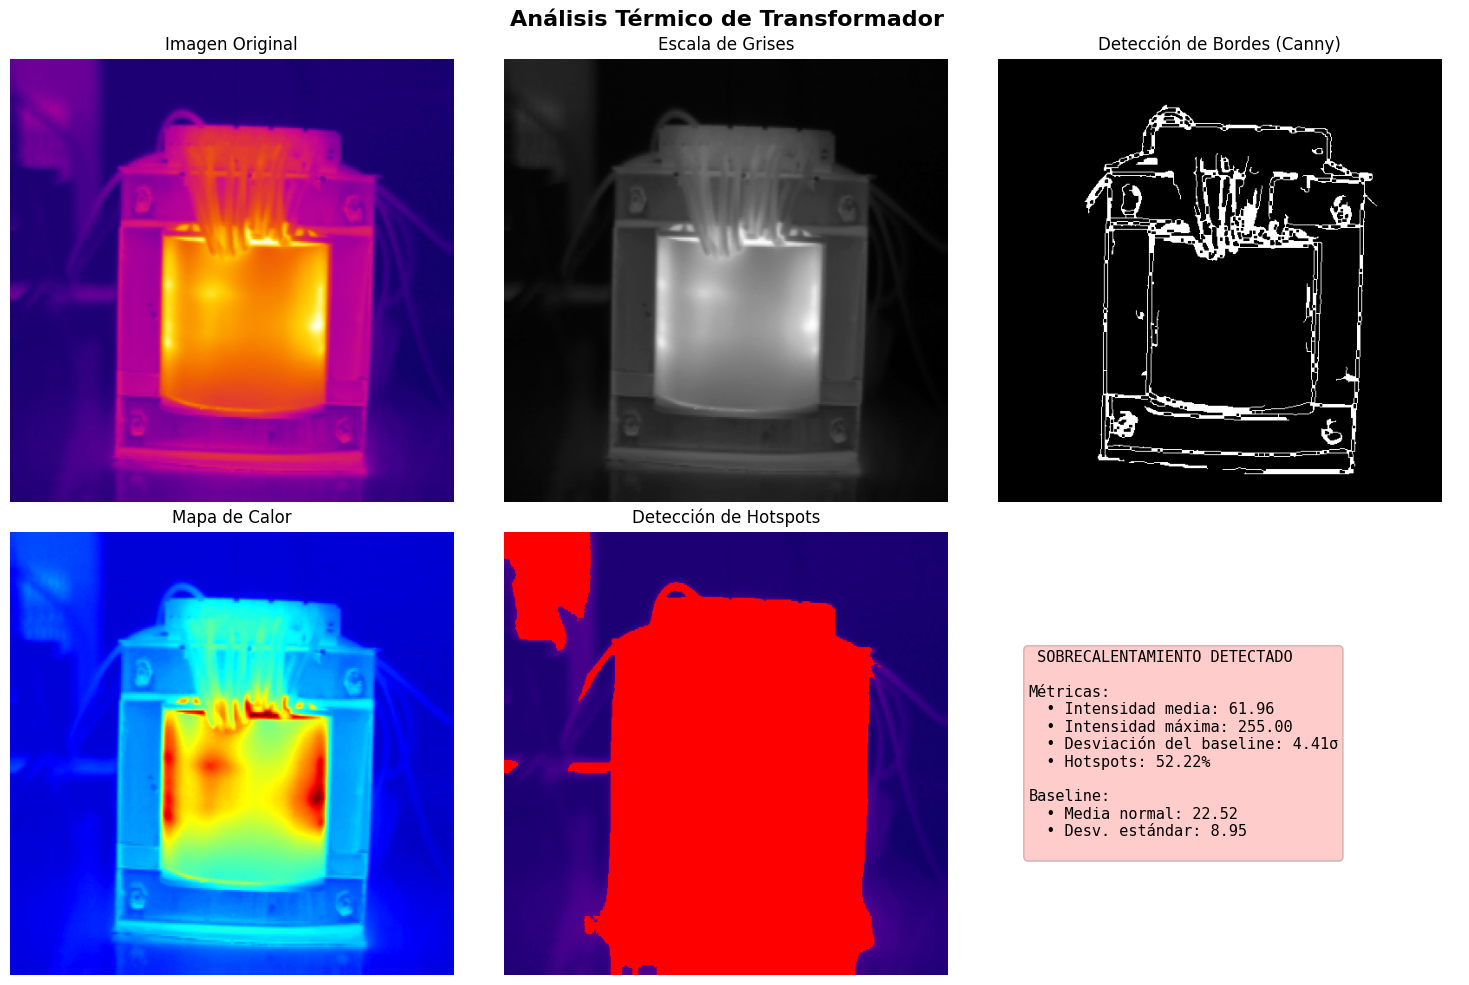

  Resultado:  SOBRECALENTAMIENTO
  Desviación: 4.41σ
  Hotspots: 52.22%
----------------------------------------------------------------------

 Análisis completado!

 Para analizar otras carpetas, cambia la variable CARPETA_IMAGENES_PRUEBA
   Carpetas disponibles: p2_80, p3_160, p4_240, p5_320, p6_400, p7_480, p8_560, p9_600


In [ ]:
# ============================================================================
# DETECTOR DE SOBRECALENTAMIENTO EN TRANSFORMADORES
# ============================================================================

# ---------- Cargar desde Google Drive ----------
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Cambiar al directorio del proyecto
RUTA_PROYECTO = '/content/drive/MyDrive/imagenes_termicas'
os.chdir(RUTA_PROYECTO)

print(f"Directorio actual: {os.getcwd()}")
print("\nCarpetas encontradas:")
!ls


# ============================================================================
# CODIGO DEL ANALIZADOR TERMICO
# ============================================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from typing import List, Tuple, Dict

class TransformerThermalAnalyzer:
    """
    Sistema de análisis térmico para detección de sobrecalentamiento en transformadores.
    Utiliza imágenes de referencia para establecer un baseline y detectar anomalías.
    """

    def __init__(self, target_size=(512, 512)):
        """
        Inicializa el analizador.

        Args:
            target_size: Tamaño al que se redimensionarán las imágenes (ancho, alto)
        """
        self.target_size = target_size
        self.baseline_stats = None

    def load_image(self, image_path: str) -> np.ndarray:
        """
        Carga una imagen BMP o cualquier formato soportado por OpenCV.

        Args:
            image_path: Ruta a la imagen

        Returns:
            Imagen cargada en formato BGR
        """
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"No se pudo cargar la imagen: {image_path}")
        return img

    def preprocess_image(self, img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Preprocesa la imagen: redimensiona y convierte a escala de grises.

        Args:
            img: Imagen en formato BGR

        Returns:
            Tupla con (imagen_redimensionada_color, imagen_escala_grises)
        """
        img_resized = cv2.resize(img, self.target_size, interpolation=cv2.INTER_AREA)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        return img_resized, img_gray

    def detect_edges(self, img_gray: np.ndarray) -> np.ndarray:
        img_norm = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX)
        blurred = cv2.GaussianBlur(img_norm, (3, 3), 0)

        sobelx = cv2.Sobel(blurred, cv2.CV_16S, 1, 0, ksize=3)
        sobely = cv2.Sobel(blurred, cv2.CV_16S, 0, 1, ksize=3)

        grad_mag = cv2.magnitude(sobelx.astype(np.float32), sobely.astype(np.float32))
        grad_mag = cv2.normalize(grad_mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        edges = cv2.Canny(grad_mag, 30, 120)

        kernel = np.ones((3, 3), np.uint8)
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        return edges

    def compute_baseline(self, normal_images_folder: str) -> Dict:
        """
        Calcula estadísticas de referencia a partir de imágenes normales.
        """
        print(f"Calculando baseline desde: {normal_images_folder}")

        intensities_list = []
        image_files = list(Path(normal_images_folder).glob("*.bmp"))
        if not image_files:
            image_files = list(Path(normal_images_folder).glob("*.jpg")) + \
                           list(Path(normal_images_folder).glob("*.png"))

        if not image_files:
            raise ValueError(f"No se encontraron imágenes en {normal_images_folder}")

        print(f"Procesando {len(image_files)} imágenes de referencia...")

        for img_path in image_files:
            img = self.load_image(str(img_path))
            _, img_gray = self.preprocess_image(img)
            intensities_list.append(img_gray.flatten())

        all_intensities = np.concatenate(intensities_list)

        baseline_stats = {
            'mean': np.mean(all_intensities),
            'std': np.std(all_intensities),
            'median': np.median(all_intensities),
            'percentile_95': np.percentile(all_intensities, 95),
            'percentile_99': np.percentile(all_intensities, 99),
            'num_images': len(image_files)
        }

        self.baseline_stats = baseline_stats

        print("Estadísticas baseline calculadas:")
        print(f"Media: {baseline_stats['mean']:.2f}")
        print(f"Desviación estándar: {baseline_stats['std']:.2f}")
        print(f"Percentil 95: {baseline_stats['percentile_95']:.2f}")
        print(f"Percentil 99: {baseline_stats['percentile_99']:.2f}")

        return baseline_stats

    def save_baseline(self, filepath: str):
        with open(filepath, 'wb') as f:
            pickle.dump(self.baseline_stats, f)
        print(f"Baseline guardado en: {filepath}")

    def load_baseline(self, filepath: str):
        with open(filepath, 'rb') as f:
            self.baseline_stats = pickle.load(f)
        print(f"Baseline cargado desde: {filepath}")

    def detect_overheating(self, img_gray: np.ndarray,
                           sensitivity: float = 2.0) -> Tuple[bool, Dict]:

        if self.baseline_stats is None:
            raise ValueError("Debe calcular o cargar el baseline primero")

        img_mean = np.mean(img_gray)
        img_max = np.max(img_gray)
        img_std = np.std(img_gray)

        baseline_mean = self.baseline_stats['mean']
        baseline_std = self.baseline_stats['std']

        deviation = (img_mean - baseline_mean) / baseline_std

        threshold_hotspot = self.baseline_stats['percentile_95']
        hotspot_mask = img_gray > threshold_hotspot
        hotspot_percentage = (np.sum(hotspot_mask) / img_gray.size) * 100

        is_overheating = (
            deviation > sensitivity or
            img_max > self.baseline_stats['percentile_99'] or
            hotspot_percentage > 5.0
        )

        metrics = {
            'mean_intensity': img_mean,
            'max_intensity': img_max,
            'std_intensity': img_std,
            'deviation_from_baseline': deviation,
            'hotspot_percentage': hotspot_percentage,
            'is_overheating': is_overheating,
            'hotspot_mask': hotspot_mask
        }

        return is_overheating, metrics

    def visualize_analysis(self, img_original: np.ndarray,
                           img_gray: np.ndarray,
                           edges: np.ndarray,
                           metrics: Dict,
                           save_path: str = None):

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Analisis Termico de Transformador', fontsize=16, fontweight='bold')

        axes[0, 0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Imagen Original')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(img_gray, cmap='gray')
        axes[0, 1].set_title('Escala de Grises')
        axes[0, 1].axis('off')

        axes[0, 2].imshow(edges, cmap='gray')
        axes[0, 2].set_title('Deteccion de Bordes')
        axes[0, 2].axis('off')

        heatmap = cv2.applyColorMap(img_gray, cv2.COLORMAP_JET)
        axes[1, 0].imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
        axes[1, 0].set_title('Mapa de Calor')
        axes[1, 0].axis('off')

        hotspot_overlay = img_original.copy()
        if metrics['hotspot_mask'].any():
            hotspot_overlay[metrics['hotspot_mask']] = [0, 0, 255]
        axes[1, 1].imshow(cv2.cvtColor(hotspot_overlay, cv2.COLOR_BGR2RGB))
        axes[1, 1].set_title('Deteccion de Hotspots')
        axes[1, 1].axis('off')

        axes[1, 2].axis('off')
        resultado = "SOBRECALENTAMIENTO DETECTADO" if metrics['is_overheating'] else "Temperatura Normal"
        color = 'red' if metrics['is_overheating'] else 'green'

        info_text = f"{resultado}\n\n"
        info_text += f"Metricas:\n"
        info_text += f"  Intensidad media: {metrics['mean_intensity']:.2f}\n"
        info_text += f"  Intensidad maxima: {metrics['max_intensity']:.2f}\n"
        info_text += f"  Desviacion del baseline: {metrics['deviation_from_baseline']:.2f} sigma\n"
        info_text += f"  Hotspots: {metrics['hotspot_percentage']:.2f}%\n\n"

        if self.baseline_stats:
            info_text += f"Baseline:\n"
            info_text += f"  Media normal: {self.baseline_stats['mean']:.2f}\n"
            info_text += f"  Desv estandar: {self.baseline_stats['std']:.2f}\n"

        axes[1, 2].text(0.1, 0.5, info_text, fontsize=11,
                       verticalalignment='center', family='monospace',
                       bbox=dict(boxstyle='round', facecolor=color, alpha=0.2))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Visualizacion guardada en: {save_path}")

        plt.show()

    def analyze_image(self, image_path: str, sensitivity: float = 2.0,
                      visualize: bool = True, save_path: str = None) -> Dict:

        print(f"Analizando: {Path(image_path).name}")

        img = self.load_image(image_path)

        img_resized, img_gray = self.preprocess_image(img)

        edges = self.detect_edges(img_gray)

        is_overheating, metrics = self.detect_overheating(img_gray, sensitivity)

        if visualize:
            self.visualize_analysis(img_resized, img_gray, edges, metrics, save_path)

        return metrics


# ============================================================================
# EJEMPLO DE USO EN COLAB
# ============================================================================

def main():
    CARPETA_IMAGENES_NORMALES = "p1_Noload"
    CARPETA_IMAGENES_PRUEBA = "p9_600"
    BASELINE_FILE = "baseline_stats.pkl"

    print("=" * 70)
    print("SISTEMA DE DETECCION DE SOBRECALENTAMIENTO EN TRANSFORMADORES")
    print("=" * 70)

    analyzer = TransformerThermalAnalyzer(target_size=(512, 512))

    if not os.path.exists(BASELINE_FILE):
        print("\nPASO 1: Calculando baseline con imagenes normales")
        print("-" * 70)
        try:
            analyzer.compute_baseline(CARPETA_IMAGENES_NORMALES)
            analyzer.save_baseline(BASELINE_FILE)
        except Exception as e:
            print(f"Error al calcular baseline: {e}")
            print(f"Asegurese de que la carpeta '{CARPETA_IMAGENES_NORMALES}' existe y contiene imagenes.")
            return
    else:
        print("Cargando baseline existente...")
        analyzer.load_baseline(BASELINE_FILE)

    print("=" * 70)
    print("PASO 2: Analizando imagenes de prueba")
    print("=" * 70)

    test_images = list(Path(CARPETA_IMAGENES_PRUEBA).glob("*.bmp"))
    if not test_images:
        test_images = list(Path(CARPETA_IMAGENES_PRUEBA).glob("*.jpg")) + \
                       list(Path(CARPETA_IMAGENES_PRUEBA).glob("*.png"))

    if not test_images:
        print(f"No se encontraron imagenes en {CARPETA_IMAGENES_PRUEBA}")
        print("\nCarpetas disponibles:")
        !ls -d p*/
        return

    print(f"Encontradas {len(test_images)} imagenes para analizar\n")

    for img_path in test_images[:16:5]:
        save_path = f"resultado_{img_path.stem}.png"

        try:
            metrics = analyzer.analyze_image(
                str(img_path),
                sensitivity=2.0,
                visualize=True,
                save_path=save_path
            )

            status = "SOBRECALENTAMIENTO" if metrics['is_overheating'] else "NORMAL"
            print(f"Resultado: {status}")
            print(f"Desviacion: {metrics['deviation_from_baseline']:.2f} sigma")
            print(f"Hotspots: {metrics['hotspot_percentage']:.2f}%")
            print("-" * 70)
        except Exception as e:
            print(f"Error al analizar {img_path.name}: {e}")
            print("-" * 70)

    print("Analisis completado.")
    print("Para analizar otras carpetas, cambie la variable CARPETA_IMAGENES_PRUEBA")
    print("Carpetas disponibles: p2_80, p3_160, p4_240, p5_320, p6_400, p7_480, p8_560, p9_600")


# ============================================================================
# EJECUTAR EL ANALISIS
# ============================================================================

if __name__ == "__main__":
    main()
